In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
!pip install transformers torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification,get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
df=pd.read_csv("drive/MyDrive/kaggle_aml5/train.csv",encoding="iso-8859-1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
len(df)
def preprocessing(text):
  regex = r'[^\w\s]|[\U0001f600-\U0001f64f\U0001f300-\U0001f5ff\U0001f680-\U0001f6ff\U0001f1e0-\U0001f1ff]'
  text=re.sub(regex," ",text)
  text=re.sub("\.|\,|\/|\-"," ",text) 
  text=re.sub("\s*\s"," ",text)
  return text

In [5]:
map_dict = {"neutral":0,"positive":1,"negative":2}
for i in range(len(df)):
  df.loc[i,"text"]=preprocessing(str(df.loc[i,"text"]))
df["sentiment"]=df["sentiment"].replace(map_dict)
df=df[["text","sentiment"]]


In [6]:
from sklearn.model_selection import train_test_split 
train_text,test_text,train_labels,test_labels=train_test_split(df["text"],df["sentiment"],test_size=0.4)
val_text,test_text,val_labels,test_labels=train_test_split(test_text,test_labels,test_size=0.4)
     

In [7]:
df[:10]

,text,sentiment
0,I d have responded if I were going,0
1,Sooo SAD I will miss you here in San Diego,2
2,my boss is bullying me,2
3,what interview leave me alone,2
4,Sons of why couldn t they put them on the rel...,2
5,http www dothebouncy com smf some shameless pl...,0
6,2am feedings for the baby are fun when he is a...,1
7,Soooo high,0
8,Both of you,0
9,Journey Wow u just became cooler hehe is that...,1


In [8]:
from transformers import BertTokenizer, TFBertForSequenceClassification
num_classes = 3
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [9]:
def convert_example_to_feature(review):
  return bert_tokenizer.encode_plus(review, 
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )
     

In [10]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  todict = {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }
  return todict, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


In [11]:
batch_size = 8


In [12]:
ds_train = zip(train_text, train_labels)
ds_test = zip(test_text, test_labels)
ds_train_encoded = encode_examples(ds_train).shuffle(len(train_text)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [13]:
# import os
# os.mkdir("drive/MyDrive/aml_5")
model_save_path = 'drive/MyDrive/aml_5/bert_model.h5'

path = "/content/"

## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes)

bert_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [14]:

# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 3

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)
     

In [15]:
history = bert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded, verbose = 1)
bert_model.save_weights(model_save_path)


Epoch 1/3
2061/2061 [==============================] - 2151s 1s/step - loss: 0.6100 - accuracy: 0.7462 - val_loss: 0.5489 - val_accuracy: 0.7794
Epoch 2/3
2061/2061 [==============================] - 2089s 1s/step - loss: 0.4210 - accuracy: 0.8431 - val_loss: 0.5942 - val_accuracy: 0.7876
Epoch 3/3
2061/2061 [==============================] - 2071s 1s/step - loss: 0.2600 - accuracy: 0.9076 - val_loss: 0.6455 - val_accuracy: 0.7663


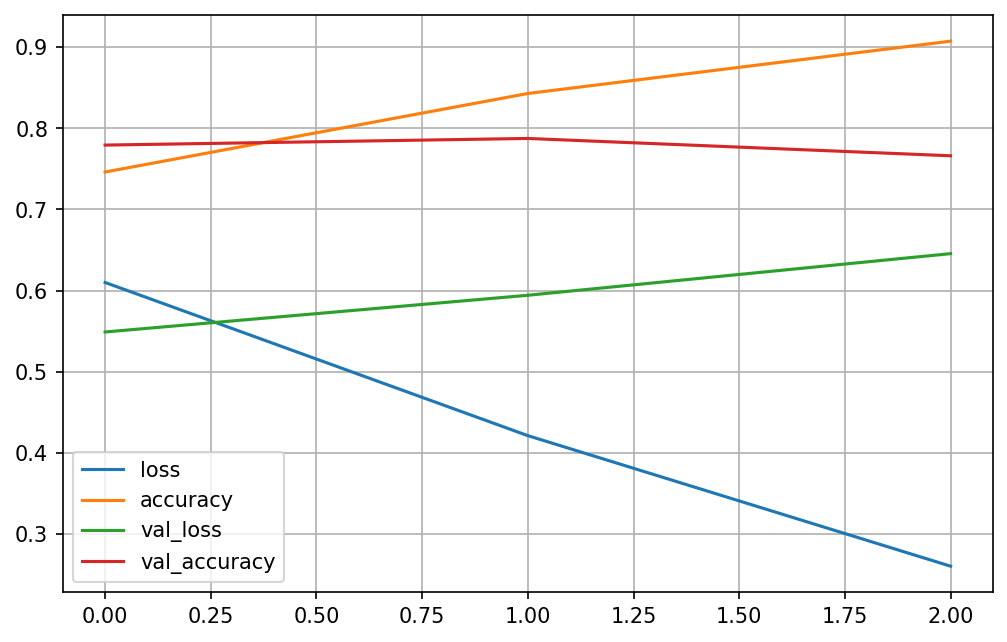

In [16]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

plot2(history)

In [17]:
bert_model.evaluate(ds_test_encoded,
                    batch_size=batch_size)

550/550 [==============================] - 185s 336ms/step - loss: 0.6455 - accuracy: 0.7663


[0.6455373167991638, 0.7662574052810669]

In [18]:
y_test_pred = bert_model.predict(ds_test_encoded,
                                 batch_size=batch_size)

550/550 [==============================] - 187s 333ms/step


In [19]:
y_test_pred_class = y_test_pred[0].argmax(axis=1)


In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j,
                     i,
                     "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j,
                     i,
                     "{:,}".format(cm[i, j]),
                      horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.show()

In [21]:
import sklearn
cm = sklearn.metrics.confusion_matrix(test_labels,
                                      y_test_pred_class,
                                      normalize=None)

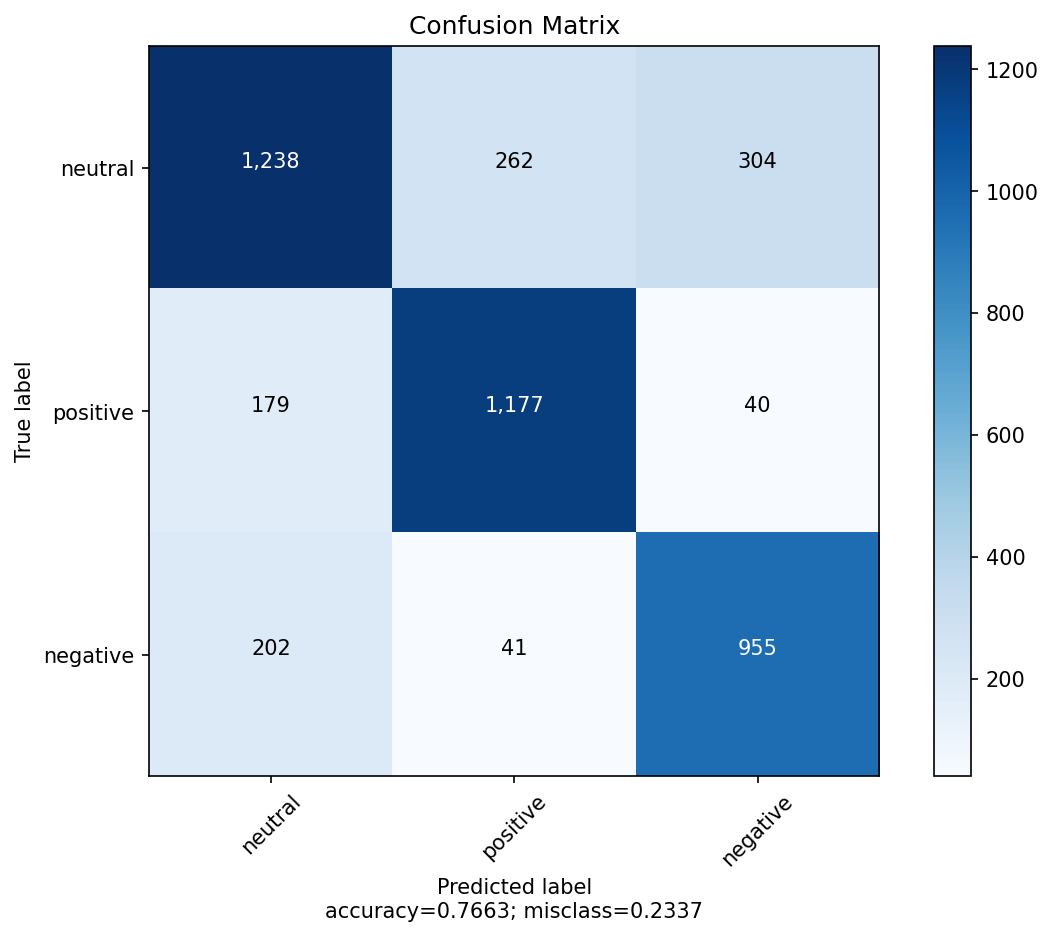

In [22]:
plot_confusion_matrix(cm,
                      normalize=False,
                      target_names=['neutral', 'positive',"negative"],
                      title="Confusion Matrix")